# 1 Frame Synchronization and CFO Estimation using MTL

This notebook uses MTL to train FCNs that can do frame sync and CFO estimation.

In [37]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from helper_functions import *
from helper_functions_mtl import *

## Params
Keep same for both MTL and non-MTL DNNs

In [38]:
# Models to train per config
num_models = 5

# Preamble config
preamble_length = 32
preamble_seq = signal.max_len_seq(6)[0][:preamble_length]

# training params
num_examples = 8192
train_snr = 0
batch_size = 32
num_epochs = 30
reg = 0.001
learn_rate = 0.001

# loss functions
loss_fn = nn.CrossEntropyLoss()
loss_fn_cfo = nn.MSELoss()

# test params
cfos_sweep = np.arange(1,70)*1e3 # for constant snr, changing cfo tests
snr_range=np.arange(-10,11) # for DERs tests
cfos = [10e3, 20e3, 30e3]
test_snrs = [-10, -5, 0, 5, 10]

runs_sweep = 50
runs = 500

## Visualize data

In [39]:
train_data, labels, labels_cfo = gen_training_data_mtl(preamble_seq, num_examples=num_examples, 
                                                       snr=30, add_phase_offset=False, add_carrier_offset=True, 
                                                       max_freq_offset=1, signal_length=250)

In [40]:
waveform_sample = train_data[0].real + train_data[1].imag*1j

In [41]:
labels[0]
label = np.zeros(len(waveform_sample))
label[labels[0]] = 1

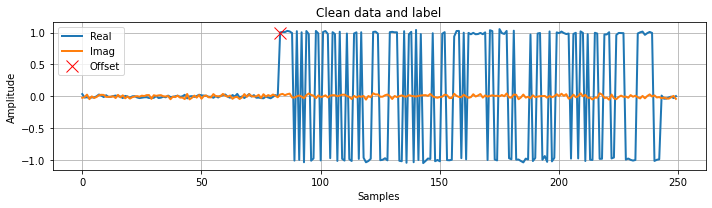

In [42]:
plt.figure(figsize=(10,3))
plt.plot(waveform_sample.real, linewidth=2)
plt.plot(waveform_sample.imag, linewidth=2)
plt.plot(labels[0], 1, 'rx', markersize=12)
plt.grid()
plt.legend(['Real', 'Imag', 'Offset'])
plt.title('Clean data and label')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
# plt.savefig('figures/cfo_training_data_0.png', dpi=300, bbox_inches='tight')

In [43]:
new_waveform = waveform_sample*np.exp(1j*2*np.pi*(2e3/1e6)*np.arange(len(waveform_sample)))

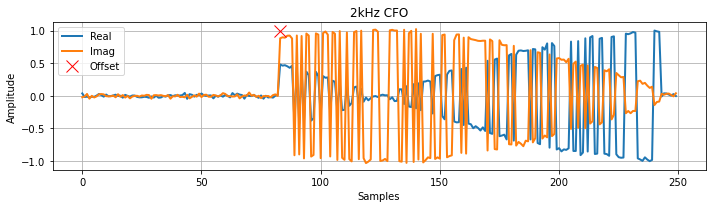

In [44]:
plt.figure(figsize=(10,3))
plt.plot(new_waveform.real, linewidth=2)
plt.plot(new_waveform.imag, linewidth=2)
plt.plot(labels[0], 1, 'rx', markersize=12)
plt.grid()
plt.legend(['Real', 'Imag', 'Offset'])
plt.title('2kHz CFO')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
# plt.savefig('figures/cfo_training_data_1.png', dpi=300, bbox_inches='tight')

In [45]:
new_waveform_noisy = awgn(new_waveform, 0)

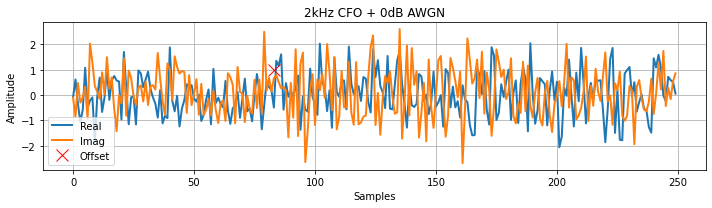

In [46]:
plt.figure(figsize=(10,3))
plt.plot(new_waveform_noisy.real, linewidth=2)
plt.plot(new_waveform_noisy.imag, linewidth=2)
plt.plot(labels[0], 1, 'rx', markersize=12)
plt.grid()
plt.legend(['Real', 'Imag', 'Offset'])
plt.title('2kHz CFO + 0dB AWGN')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
# plt.savefig('figures/cfo_training_data_2.png', dpi=300, bbox_inches='tight')

## Define baseline

In [47]:
der_baseline10 = calculate_baseline(preamble_seq, snr_range=snr_range, num_iter=1000, add_phase_offset=True, carrier_offset=10e3)
der_baseline20 = calculate_baseline(preamble_seq, snr_range=snr_range, num_iter=1000, add_phase_offset=True, carrier_offset=20e3)
der_baseline30 = calculate_baseline(preamble_seq, snr_range=snr_range, num_iter=1000, add_phase_offset=True, carrier_offset=30e3)

## Datasets

In [48]:
for num_examples in [4096, 8192, 16384]:
    for train_snr in [0, 5]:
        # training data
        train_data, labels, labels_cfo = gen_training_data_mtl(preamble_seq, num_examples=num_examples, snr=5, add_phase_offset=True, add_carrier_offset=True)
        train_data, labels, labels_cfo = preprocess_mtl(train_data, labels, labels_cfo, to_onehot=True)

        train_dataset = torch.utils.data.TensorDataset(train_data, labels)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # validation data
        val_data, val_labels, val_labels_cfo = gen_training_data_mtl(preamble_seq, num_examples=256, add_phase_offset=True, add_carrier_offset=True)
        val_data, val_labels, val_labels_cfo = preprocess_mtl(val_data, val_labels, val_labels_cfo, to_onehot=True)

        val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

        dataset = {'train_data': train_data,
                   'labels': labels,
                   'labels_cfo': labels_cfo,
                   'val_data': val_data,
                   'val_labels': val_labels,
                   'val_labels_cfo': val_labels_cfo}

        torch.save(dataset, f"data/fcn_mtl_data_{num_examples}_{train_snr}_db.pt")

## Simple FCN

In [49]:
class preamble_detector(nn.Module):
    def __init__(self, num_layers=3, num_filters=32, width=35):
        super(preamble_detector, self).__init__()
        
        pad = int((width-1)/2)
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad)))
        self.conv.add_module(f"relu0", torch.nn.ReLU())
        
        for i in range(num_layers-2):
            self.conv.add_module(f"conv{i+1}", nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad)))
            self.conv.add_module(f"relu{i+1}", torch.nn.ReLU())
        
        self.conv.add_module(f"conv_last", nn.Conv2d(num_filters, 1, 1, 1))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [50]:
def train_model(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=30):
    
    train_accs, val_accs = [], []
    losses, val_losses = [], []
    
    best_loss = np.inf
    
    for epoch in range(num_epochs):
        running_loss = 0
        accuracies = torch.zeros((len(train_loader), train_loader.batch_size)).cuda()
        val_accuracies = torch.zeros((len(val_loader), val_loader.batch_size)).cuda()
        
        for i, (x_train, y_train) in enumerate(train_loader):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x_train)
            loss = loss_fn(outputs, y_train)

            loss.backward()
            optimizer.step()

            running_loss = running_loss + loss.item()
            
            with torch.no_grad():
                accuracies[i] = torch.sum(y_train.argmax(axis=1) == outputs.argmax(axis=1))/train_loader.batch_size

        losses.append(running_loss/len(train_loader))
        
        with torch.no_grad():

            running_val_loss = 0

            for j, (x_val, y_val) in enumerate(val_loader):

                # evaluate validation loss
                val_outputs = model(x_val)
                val_loss = loss_fn(val_outputs, y_val)
                
                running_val_loss = running_val_loss + val_loss.item()
                val_accuracies[j] = torch.sum(y_val.argmax(axis=1) == val_outputs.argmax(axis=1))/val_loader.batch_size

            val_losses.append(running_val_loss/len(val_loader))
            
        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
    
        train_accs.append(torch.mean(accuracies).cpu())
        val_accs.append(torch.mean(val_accuracies).cpu())
    
    model.load_state_dict(saved_model)
            
    return model, losses, val_losses, train_accs, val_accs

In [51]:
dataset = torch.load(f'data/fcn_mtl_data_{num_examples}_{train_snr}_db.pt')

train_data = dataset['train_data']
labels = dataset['labels']
labels_cfo = dataset['labels_cfo']
val_data = dataset['val_data']
val_labels = dataset['val_labels']
val_labels_cfo = dataset['val_labels_cfo']

train_dataset = torch.utils.data.TensorDataset(train_data, labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

models = []
for i in range(num_models):
    print(f"iter {i}...")
    torch.manual_seed(i)
    detector = preamble_detector()
    detector.cuda()

    optimizer = optim.Adam(detector.parameters(), lr=learn_rate, weight_decay=reg)

    detector, losses, val_losses, train_accs, val_accs = train_model(detector, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs)

    model_config = {"weights": detector.state_dict(),
                    "losses": losses,
                    "val_losses": val_losses,
                    "num_epochs": num_epochs,
                    "accs": train_accs,
                    "val_accs": val_accs}

    models.append(model_config)
torch.save(models, f"baseline/models/{preamble_length}_baseline_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}.pt")

iter 0...
val_losses[-1] = 0.0006674450996797532, best_loss = inf, model saved at 0
val_losses[-1] = 0.00032258008286589757, best_loss = 0.0006674450996797532, model saved at 1
val_losses[-1] = 0.00021398108219727874, best_loss = 0.00032258008286589757, model saved at 2
val_losses[-1] = 0.0001611938068890595, best_loss = 0.00021398108219727874, model saved at 3
val_losses[-1] = 0.0001503234489064198, best_loss = 0.0001611938068890595, model saved at 4
val_losses[-1] = 0.00011773229834943777, best_loss = 0.0001503234489064198, model saved at 6
val_losses[-1] = 7.830137610653765e-05, best_loss = 0.00011773229834943777, model saved at 7
val_losses[-1] = 6.37065365935996e-05, best_loss = 7.830137610653765e-05, model saved at 18
val_losses[-1] = 5.723473896068754e-05, best_loss = 6.37065365935996e-05, model saved at 25
val_losses[-1] = 5.135517176313442e-05, best_loss = 5.723473896068754e-05, model saved at 26
iter 1...
val_losses[-1] = 0.0006636254111072049, best_loss = inf, model saved at

In [53]:
for test_snr in test_snrs:
    print(f'running {test_snr}')
    results = []
    for model in torch.load(f"baseline/models/{preamble_length}_baseline_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}.pt"):
        detector = preamble_detector()
        detector.load_state_dict(model['weights'])

        ders = []
        for cfo in cfos_sweep:
            der = test_detector(detector, preamble_seq, num_iter=runs, snr_range=[test_snr], add_phase_offset=True, carrier_offset=cfo, add_channel=False)
            ders.append(der)

        result = {"ders": ders,
                  "model": model,
                  "cfos": cfos_sweep,
                  "test_snr": test_snr}

        results.append(result)
    torch.save(results, f'baseline/results/fs_baseline_{test_snr}db.pt')

running -10
running -5
running 0
running 5


In [54]:
for cfo in cfos:
    print(f'Evaling {cfo}')
    results = []
    for model in torch.load(f"baseline/models/{preamble_length}_baseline_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}.pt"):
        detector = preamble_detector()
        detector.load_state_dict(model['weights'])

        ders_snr = test_detector(detector, preamble_seq, num_iter=runs, snr_range=snr_range, 
                                     add_phase_offset=True, carrier_offset=cfo, add_channel=False)

        result = {"ders": ders_snr,
                  "model": model,
                  "cfo": cfo,
                  "snr_range": snr_range}

        results.append(result)
    torch.save(results, 
               f"baseline/results/{preamble_length}_baseline_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}_ders_vs_snr_{cfo}.pt")

Evaling 10000.0
Evaling 20000.0
Evaling 30000.0


## FCN with MTL

In [55]:
class preamble_detector_mtl(nn.Module):
    def __init__(self):
        super(preamble_detector_mtl, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (2,35), 1, padding=(0,17), bias=False)
        self.conv2 = nn.Conv2d(32, 32, (1,35), 1, padding=(0,17), bias=False)
        
        self.conv3 = nn.Conv2d(32,1,1,1, bias=False)
        
        # Noise estimator network
        self.cfo_estimator = nn.Sequential(
            nn.Linear(32*200,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1))

    def forward(self, x):

        # First conv layer, correlation
        x = F.relu(self.conv1(x))
        
        # 2nd conv layer, non-linearities and cleanup
        x = F.relu(self.conv2(x))
        
        y_flat = torch.flatten(x,start_dim=1)
        cfo_estimate = self.cfo_estimator(y_flat).squeeze()
        
        # Final linear / combining layer
        x = self.conv3(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x, cfo_estimate

In [56]:
detector_mtl = preamble_detector_mtl()
detector_mtl

preamble_detector_mtl(
  (conv1): Conv2d(1, 32, kernel_size=(2, 35), stride=(1, 1), padding=(0, 17), bias=False)
  (conv2): Conv2d(32, 32, kernel_size=(1, 35), stride=(1, 1), padding=(0, 17), bias=False)
  (conv3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (cfo_estimator): Sequential(
    (0): Linear(in_features=6400, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

## Train models

In [57]:
def train_model_mtl(model, optimizer, train_loader, val_loader, loss_fn, loss_fn_cfo, num_epochs=30, loss_ratios=(0.5, 0.5)):
    
    train_accs, val_accs = [], []
    losses, val_losses, losses1, losses2 = [], [], [], []
    
    best_loss = np.inf
    
    for epoch in range(num_epochs):
        running_loss, loss1, loss2 = 0, 0, 0
        accuracies = torch.zeros((len(train_loader), train_loader.batch_size)).cuda()
        val_accuracies = torch.zeros((len(val_loader), val_loader.batch_size)).cuda()
        
        for i, (x_train, y_train, z_train) in enumerate(train_loader):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, cfo = detector_mtl(x_train)
            loss_offset = loss_fn(outputs, y_train)
            loss_cfo = loss_fn_cfo(cfo, z_train)
            
            loss = loss_offset*loss_ratios[0] + loss_cfo*loss_ratios[1]

            loss.backward()
            optimizer.step()

            running_loss = running_loss + loss.item()
            loss1 = loss1 + loss_offset.item()
            loss2 = loss2 + loss_cfo.item()
            
            with torch.no_grad():
                accuracies[i] = torch.sum(y_train.argmax(axis=1) == outputs.argmax(axis=1))/train_loader.batch_size

        losses.append(running_loss/len(train_loader))
        losses1.append(loss1/len(train_loader))
        losses2.append(loss2/len(train_loader))
        
        with torch.no_grad():

            running_val_loss = 0

            for j, (x_val, y_val, z_val) in enumerate(val_loader):

                # evaluate validation loss
                val_outputs, val_cfo = model(x_val)
                val_loss1 = loss_fn(val_outputs, y_val)
                
                running_val_loss = running_val_loss + val_loss1.item()
                val_accuracies[j] = torch.sum(y_val.argmax(axis=1) == val_outputs.argmax(axis=1))/val_loader.batch_size

            val_losses.append(running_val_loss/len(val_loader))
            
        # MONITORING VAL LOSS
        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
    
        train_accs.append(torch.mean(accuracies).cpu())
        val_accs.append(torch.mean(val_accuracies).cpu())
    
    model.load_state_dict(saved_model)
            
    return model, losses, val_losses, losses1, losses2, train_accs, val_accs

In [58]:
dataset = torch.load(f'data/fcn_mtl_data_{num_examples}_{train_snr}_db.pt')

train_data = dataset['train_data']
labels = dataset['labels']
labels_cfo = dataset['labels_cfo']
val_data = dataset['val_data']
val_labels = dataset['val_labels']
val_labels_cfo = dataset['val_labels_cfo']

train_dataset = torch.utils.data.TensorDataset(train_data, labels, labels_cfo)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_cfo)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

all_loss_ratios = []
for i in range(1,10):
    models = []

    fs_weight = round(i*0.1, 1)
    cfo_weight = round(1 - i*0.1, 1)
    
    loss_ratios = (fs_weight, cfo_weight)
    
    all_loss_ratios.append(loss_ratios)

for loss_ratios in all_loss_ratios:
    models = []
    print(loss_ratios)
    for j in range(num_models):
        print(j)
        detector_mtl = preamble_detector_mtl()
        detector_mtl.cuda()

        optimizer = optim.Adam(detector_mtl.parameters(), lr=learn_rate, weight_decay=reg)

        detector_mtl, losses, val_losses, losses_fs, losses_cfo, accs, val_accs = \
        train_model_mtl(detector_mtl, optimizer, train_loader, val_loader, loss_fn, loss_fn_cfo, num_epochs=num_epochs, loss_ratios=loss_ratios)
        
        model_config = {"weights": detector_mtl.state_dict(),
                        "losses": losses,
                        "val_losses": val_losses,
                        "losses_fs": losses_fs,
                        "losses_cfo": losses_cfo,
                        "accs": accs,
                        "val_accs": val_accs}
        
        models.append(model_config)
    torch.save(models, 
               f"models/{preamble_length}_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}.pt")

(0.1, 0.9)
0
val_losses[-1] = 0.015336947748437524, best_loss = inf, model saved at 0
val_losses[-1] = 0.009074203262571245, best_loss = 0.015336947748437524, model saved at 1
val_losses[-1] = 0.006788587023038417, best_loss = 0.009074203262571245, model saved at 2
val_losses[-1] = 0.004952948307618499, best_loss = 0.006788587023038417, model saved at 3
val_losses[-1] = 0.004233134415699169, best_loss = 0.004952948307618499, model saved at 4
val_losses[-1] = 0.003744889982044697, best_loss = 0.004233134415699169, model saved at 5
val_losses[-1] = 0.003081938630202785, best_loss = 0.003744889982044697, model saved at 6
val_losses[-1] = 0.002562714464147575, best_loss = 0.003081938630202785, model saved at 7
val_losses[-1] = 0.0023040397209115326, best_loss = 0.002562714464147575, model saved at 8
val_losses[-1] = 0.002106970699969679, best_loss = 0.0023040397209115326, model saved at 9
val_losses[-1] = 0.0018849961052183062, best_loss = 0.002106970699969679, model saved at 10
val_losses

In [47]:
# test_snrs = [-10, -5, 0, 5]
# runs=100

In [98]:
all_loss_ratios = []
for i in range(1,10):
    models = []

    fs_weight = round(i*0.1, 1) #1
    cfo_weight = round(1 - i*0.1, 1)
    
    loss_ratios = (fs_weight, cfo_weight)
    
    all_loss_ratios.append(loss_ratios)

all_loss_ratios

[(0.1, 0.9),
 (0.2, 0.8),
 (0.3, 0.7),
 (0.4, 0.6),
 (0.5, 0.5),
 (0.6, 0.4),
 (0.7, 0.3),
 (0.8, 0.2),
 (0.9, 0.1)]

In [60]:
for snr in test_snrs:
    for loss_ratios in all_loss_ratios:
        models = torch.load(f"models/{preamble_length}_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}.pt")
    #     print(models)
        print(loss_ratios)
        results = []
        for model in models:
            detector_mtl = preamble_detector_mtl()
            detector_mtl.load_state_dict(model['weights'])

            mtl_ders = []
            for cfo in cfos_sweep:
                der = test_detector_mtl(detector_mtl, preamble_seq, num_iter=runs, snr_range=[snr], add_phase_offset=True, carrier_offset=cfo, add_channel=False)
                mtl_ders.append(der)

            result = {"ders": mtl_ders,
                       "model": model,
                       "cfos": cfos_sweep}

            results.append(result)
        torch.save(results, f"results/fs_{loss_ratios[0]}_{loss_ratios[1]}_{snr}db.pt")

(0.1, 0.9)
(0.2, 0.8)
(0.3, 0.7)
(0.4, 0.6)
(0.5, 0.5)
(0.6, 0.4)
(0.7, 0.3)
(0.8, 0.2)
(0.9, 0.1)
(0.1, 0.9)
(0.2, 0.8)
(0.3, 0.7)
(0.4, 0.6)
(0.5, 0.5)
(0.6, 0.4)
(0.7, 0.3)
(0.8, 0.2)
(0.9, 0.1)
(0.1, 0.9)
(0.2, 0.8)
(0.3, 0.7)
(0.4, 0.6)
(0.5, 0.5)
(0.6, 0.4)
(0.7, 0.3)
(0.8, 0.2)
(0.9, 0.1)
(0.1, 0.9)
(0.2, 0.8)
(0.3, 0.7)
(0.4, 0.6)
(0.5, 0.5)
(0.6, 0.4)
(0.7, 0.3)
(0.8, 0.2)
(0.9, 0.1)


In [61]:
cfo_loss_fn = nn.MSELoss()

preamble_detector = preamble_detector_mtl()
for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    results = []
    for model in torch.load(f"models/{preamble_length}_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}.pt"):

        weights = model['weights']
        preamble_detector.load_state_dict(weights)
        preamble_detector.cuda()

        cfo_mses = np.zeros((len(snr_range),))

        for i, test_snr in enumerate(snr_range):
            x, y, z = gen_training_data_mtl(preamble_seq, num_examples=128, snr=test_snr, add_phase_offset=True, add_carrier_offset=True)
            x, y, z = preprocess_mtl(x, y, z, to_onehot=True)

            _, z_hat = preamble_detector(x)

            cfo_mses[i] = cfo_loss_fn(z_hat, z).item()
            
        result = {"cfo_mses": cfo_mses,
                  "model": model,
                  "snr_range": snr_range}
        
        results.append(result)
    torch.save(results, f'results/cfo/mses_vs_snr_{loss_ratios[0]}_{loss_ratios[1]}.pt')

(0.1, 0.9)
(0.2, 0.8)
(0.3, 0.7)
(0.4, 0.6)
(0.5, 0.5)
(0.6, 0.4)
(0.7, 0.3)
(0.8, 0.2)
(0.9, 0.1)


In [88]:
print('Evaling ders vs snrs...')
for cfo in cfos:
    print(f'Evaling {cfo}')
    for loss_ratios in all_loss_ratios:
        print(loss_ratios)
        results = []
        for model in torch.load(f"models/{preamble_length}_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}.pt"):
            detector_mtl = preamble_detector_mtl()
            detector_mtl.load_state_dict(model['weights'])

            ders_snr = test_detector_mtl(detector_mtl, preamble_seq, num_iter=runs, snr_range=snr_range, 
                                                 add_phase_offset=True, carrier_offset=cfo, add_channel=False)

            result = {"ders": ders_snr,
                      "model": model,
                      "cfo": cfo,
                      "snr_range": snr_range}

            results.append(result)
        torch.save(results, f'results/fs_ders_vs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{cfo}.pt')

Evaling ders vs snrs...
Evaling 10000.0
(0.1, 0.9)
(0.2, 0.8)
(0.3, 0.7)
(0.4, 0.6)
(0.5, 0.5)
(0.6, 0.4)
(0.7, 0.3)
(0.8, 0.2)
(0.9, 0.1)
Evaling 30000.0
(0.1, 0.9)
(0.2, 0.8)
(0.3, 0.7)
(0.4, 0.6)
(0.5, 0.5)
(0.6, 0.4)
(0.7, 0.3)
(0.8, 0.2)
(0.9, 0.1)


## Analysis \& Visualization

In [89]:
def find_best_worst(results):
    best_acc = 0
    worst_acc = 100
    for idx, result in enumerate(results):
        mean_acc = np.mean(1-np.array(result['ders']))
        if mean_acc < worst_acc:
            worst_acc = mean_acc
            worst_idx = idx
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_idx = idx
    return best_idx, worst_idx

In [90]:
def calc_stats(path='baseline/results/fs_baseline_ders_vs_snr_10000.0khz.pt'):
    results = torch.load(path)
    best_idx, worst_idx = find_best_worst(results)
    # plt.plot(results[0]['cfos'], 1-np.array(ders_per_cfo_5))
    for idx, result in enumerate(results):
        if idx == best_idx:
            mean_fcn_best = np.mean(1-np.array(result['ders']))
        if idx == worst_idx:
            mean_fcn_worst = np.mean(1-np.array(result['ders']))
    mean_fcn = np.mean(np.array([1-result['ders'] for result in results]).mean(axis=0))
    
    return mean_fcn_best, mean_fcn, mean_fcn_worst

In [97]:
all_loss_ratios

[(0.1, 0.0),
 (0.2, 0.0),
 (0.3, -0.0),
 (0.4, 0.0),
 (0.5, 0.0),
 (0.6, -0.0),
 (0.7, -0.0),
 (0.8, 0.0),
 (0.9, 0.0)]

In [92]:
cfos = [10e3, 30e3]

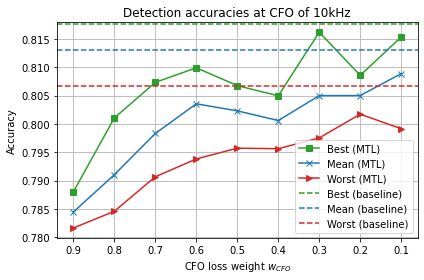

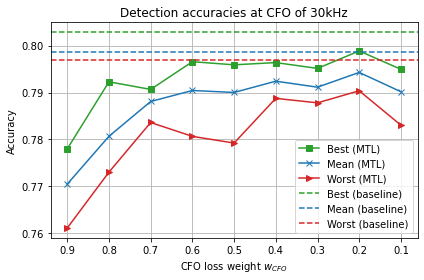

In [99]:
# all_loss_ratios = []
# for i in range(1,10):
#     models = []

#     fs_weight = 1#round(i*0.1, 1) #1
#     cfo_weight = round(fs_weight - i*0.1, 1)
    
#     loss_ratios = (fs_weight, cfo_weight)
    
#     all_loss_ratios.append(loss_ratios)

for cfo in cfos:

    bests, means, worsts = [], [], []

    for loss_ratios in all_loss_ratios:
#         best, mean, worst = calc_stats(path=f'results/{preamble_length}_{num_examples}_examples_{train_snr}_db_ders_vs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{cfo}.pt')
        best, mean, worst = calc_stats(f'results/fs_ders_vs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{cfo}.pt')
        bests.append(best)
        means.append(mean)
        worsts.append(worst)

    baseline_best, baseline_mean, baseline_worst = \
    calc_stats(path=f"baseline/results/{preamble_length}_baseline_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}_ders_vs_snr_{cfo}.pt")

    legend = [f'{loss_ratios[1]}' for loss_ratios in all_loss_ratios]

    plt.figure()
    plt.plot(np.array(bests), '-s', color='C2')
    plt.plot(np.array(means), '-x', color='C0')
    plt.plot(np.array(worsts), '->', color='C3')
    plt.axhline(y=baseline_best, color='C2', linestyle='--')
    plt.axhline(y=baseline_mean, color='C0', linestyle='--')
    plt.axhline(y=baseline_worst, color='C3', linestyle='--')
    plt.legend(['Best (MTL)', 'Mean (MTL)', 'Worst (MTL)', 'Best (baseline)', 'Mean (baseline)', 'Worst (baseline)'], loc='lower right')
    plt.xticks(np.arange(len(all_loss_ratios)), legend)
    plt.xlabel(r'CFO loss weight $w_{CFO}$'); plt.ylabel('Accuracy')
    plt.title(f'Detection accuracies at CFO of {round(cfo/1e3)}kHz')
    plt.grid()
    plt.tight_layout()
    
#     plt.ylim([0.7,0.85])
    # plt.savefig(f'figures/mean_accs_loss_tradeoffs_only_cfo_{round(cfo/1e3)}khz.png', dpi=300, bbox_inches='tight')

In [71]:
def plot_results(baseline_path='baseline/results/fs_baseline_0db.pt', result_path='results/fs_0.9_0.1_0db.pt', save=None, slices=-70):
    plt.figure()
#     slices = -70
    results = torch.load(baseline_path)
    best_idx, worst_idx = find_best_worst(results)
    # plt.plot(results[0]['cfos'], 1-np.array(ders_per_cfo_5))
    for idx, result in enumerate(results):
        if idx == best_idx:
            plt.plot(result['cfos'][slices:]/1e3, 1-np.array(result['ders'][slices:]), '-C0')
            mean_fcn_best = np.mean(1-np.array(result['ders']))
        else:
            plt.plot(result['cfos'][slices:]/1e3, 1-np.array(result['ders'][slices:]), '-C0', alpha=0.2)
    plt.plot(result['cfos'][slices:]/1e3, 1-np.array([result['ders'][slices:] for result in results]).mean(axis=0), '--C0', linewidth=2)
    mean_fcn = np.mean(1-np.array([result['ders'] for result in results]).mean(axis=0))

    results = torch.load(result_path)
    best_idx, worst_idx = find_best_worst(results)
    for idx, result in enumerate(results):
        if idx == best_idx:
#             plt.plot(np.array(result['cfos'])/1e3, 1-np.array(result['ders']), '-C3')
            plt.plot(cfos_sweep[slices:]/1e3, 1-np.array(result['ders'][slices:]), '-C3')
            mean_mtl_best = np.mean(1-np.array(result['ders']))
        else:
#             plt.plot(result['cfos']/1e3, 1-np.array(result['ders']), '-C3', alpha=0.2)
            plt.plot(cfos_sweep[slices:]/1e3, 1-np.array(result['ders'][slices:]), '-C3', alpha=0.2)
    
#     plt.plot(np.array(result['cfos'])/1e3, 1-np.array([result['ders'] for result in results]).mean(axis=0), '--C3', linewidth=2)
    plt.plot(cfos_sweep[slices:]/1e3, 1-np.array([result['ders'][slices:] for result in results]).mean(axis=0), '--C3', linewidth=2)
    mean_mtl = np.mean(1-np.array([result['ders'] for result in results]).mean(axis=0))

    custom_lines = [Line2D([0], [0], color='C0'),
                    Line2D([0], [0], color='C0', linestyle='--'),
                    Line2D([0], [0], color='C3'),
                    Line2D([0], [0], color='C3', linestyle='--')]

    plt.legend(custom_lines, [f'Best FCN ({round(mean_fcn_best,3)})', f'Mean FCN  ({round(mean_fcn,3)})', f'Best FCN+MTL ({round(mean_mtl_best,3)})', f'Mean FCN+MTL  ({round(mean_mtl,3)})'])
    plt.grid()
    plt.xlabel('Carrier Frequency Offset, kHz'); plt.ylabel('Accuracy')
    plt.title(f"Accuracy at SNR={baseline_path.split('db')[0].split('_')[-1]}dB")
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')

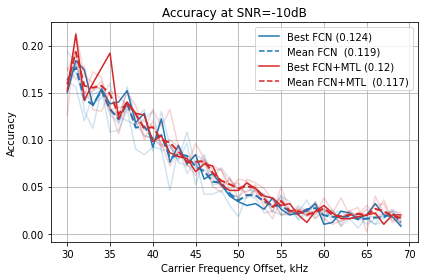

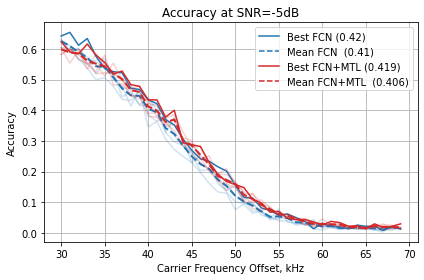

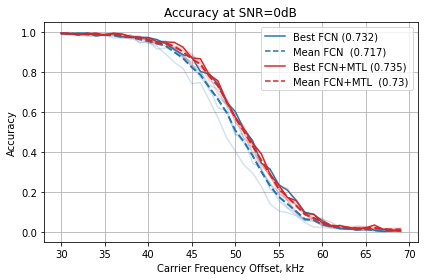

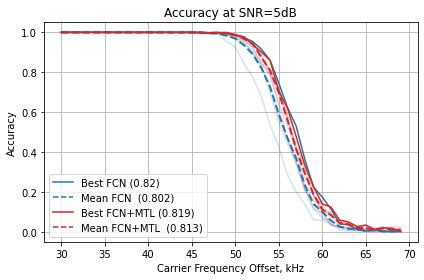

In [74]:
plot_results(baseline_path='baseline/results/fs_baseline_-10db.pt', result_path='results/fs_0.8_0.2_-10db.pt',
             slices=-40, save='figures/fs_fcn_vs_mtl_-10db.png')
plot_results(baseline_path='baseline/results/fs_baseline_-5db.pt', result_path='results/fs_0.8_0.2_-5db.pt',
             slices=-40, save='figures/fs_fcn_vs_mtl_-5db.png')
plot_results(baseline_path='baseline/results/fs_baseline_0db.pt', result_path='results/fs_0.8_0.2_0db.pt',
             slices=-40, save='figures/fs_fcn_vs_mtl_0db.png')
plot_results(baseline_path='baseline/results/fs_baseline_5db.pt', result_path='results/fs_0.8_0.2_5db.pt',
             slices=-40, save='figures/fs_fcn_vs_mtl_5db.png')
# plot_results(baseline_path='baseline/results/fs_baseline_10db.pt', result_path='results/fs_0.8_0.2_10db.pt',
#              slices=-40, save='figures/fs_fcn_vs_mtl_10db.png')

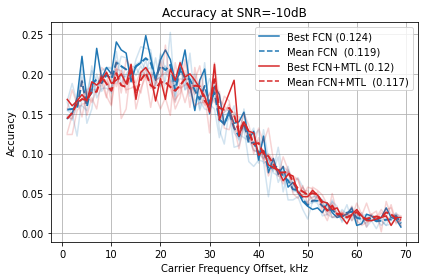

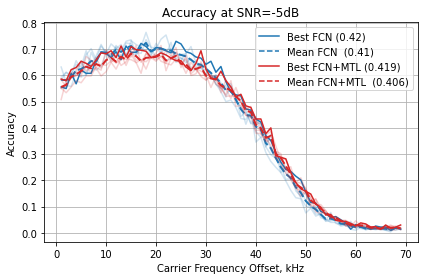

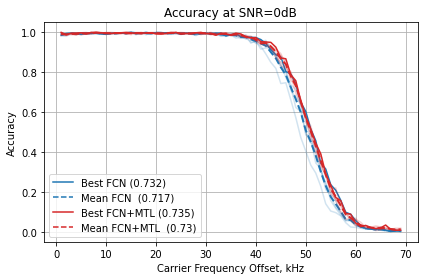

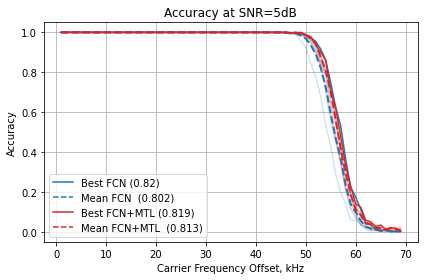

In [75]:
plot_results(baseline_path='baseline/results/fs_baseline_-10db.pt', result_path='results/fs_0.8_0.2_-10db.pt',
             slices=-70, save='figures/fs_fcn_vs_mtl_-10db_full.png')
plot_results(baseline_path='baseline/results/fs_baseline_-5db.pt', result_path='results/fs_0.8_0.2_-5db.pt',
             slices=-70, save='figures/fs_fcn_vs_mtl_-5db_full.png')
plot_results(baseline_path='baseline/results/fs_baseline_0db.pt', result_path='results/fs_0.8_0.2_0db.pt',
             slices=-70, save='figures/fs_fcn_vs_mtl_0db_full.png')
plot_results(baseline_path='baseline/results/fs_baseline_5db.pt', result_path='results/fs_0.8_0.2_5db.pt',
             slices=-70, save='figures/fs_fcn_vs_mtl_5db_full.png')
# plot_results(baseline_path='baseline/results/fs_baseline_10db.pt', result_path='results/fs_0.8_0.2_10db.pt',
#              slices=-70, save='figures/fs_fcn_vs_mtl_10db_full.png')

## CFO eval

In [9]:
dataset = torch.load(f'data/fcn_mtl_data_{num_examples}_{train_snr}_db.pt')

train_data = dataset['train_data']
labels = dataset['labels']
labels_cfo = dataset['labels_cfo']
val_data = dataset['val_data']
val_labels = dataset['val_labels']
val_labels_cfo = dataset['val_labels_cfo']

train_dataset = torch.utils.data.TensorDataset(train_data, labels, labels_cfo)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_cfo)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Analysis \& Visualization

In [84]:
def find_best_worst(results):
    best_acc = 0
    worst_acc = 100
    for idx, result in enumerate(results):
        mean_acc = np.mean(1-np.array(result['ders']))
        if mean_acc < worst_acc:
            worst_acc = mean_acc
            worst_idx = idx
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_idx = idx
    return best_idx, worst_idx

In [85]:
def calc_stats(path='baseline/results/fs_baseline_ders_vs_snr_10000.0khz.pt'):
    results = torch.load(path)
    best_idx, worst_idx = find_best_worst(results)
    # plt.plot(results[0]['cfos'], 1-np.array(ders_per_cfo_5))
    for idx, result in enumerate(results):
        if idx == best_idx:
            mean_fcn_best = np.mean(1-np.array(result['ders']))
        if idx == worst_idx:
            mean_fcn_worst = np.mean(1-np.array(result['ders']))
    mean_fcn = np.mean(np.array([1-result['ders'] for result in results]).mean(axis=0))
    
    return mean_fcn_best, mean_fcn, mean_fcn_worst

In [86]:
all_loss_ratios = []
for i in range(1,10):
    models = []

    fs_weight = round(i*0.1, 1)
    cfo_weight = round(1 - fs_weight, 1)
    
    loss_ratios = (fs_weight, cfo_weight)
    
    all_loss_ratios.append(loss_ratios)

In [87]:
for cfo in cfos:
#     all_loss_ratios = []
#     for i in range(1,10):
#         models = []

#         fs_weight = round(i*0.1, 1)
#         cfo_weight = round(1 - fs_weight, 1)

#         loss_ratios = (fs_weight, cfo_weight)

#         all_loss_ratios.append(loss_ratios)

    bests, means, worsts = [], [], []

    for loss_ratios in all_loss_ratios:
#         best, mean, worst = calc_stats(path=f'results/{preamble_length}_{num_examples}_examples_{train_snr}_db_ders_vs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{cfo}.pt')
        best, mean, worst = calc_stats(f'results/fs_ders_vs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{cfo}.pt')
        bests.append(best)
        means.append(mean)
        worsts.append(worst)

    baseline_best, baseline_mean, baseline_worst = \
    calc_stats(path=f"baseline/results/{preamble_length}_baseline_{num_examples}_examples_{train_snr}_db_{str(loss_fn).strip('()')}_ders_vs_snr_{cfo}.pt")

    legend = [f'{loss_ratios[0]}/{loss_ratios[1]}' for loss_ratios in all_loss_ratios]

    plt.figure()
    plt.plot(np.array(bests), '-s', color='C2')
    plt.plot(np.array(means), '-x', color='C0')
    plt.plot(np.array(worsts), '->', color='C3')
    plt.axhline(y=baseline_best, color='C2', linestyle='--')
    plt.axhline(y=baseline_mean, color='C0', linestyle='--')
    plt.axhline(y=baseline_worst, color='C3', linestyle='--')
    plt.legend(['Best (MTL)', 'Mean (MTL)', 'Worst (MTL)', 'Best (baseline)', 'Mean (baseline)', 'Worst (baseline)'], loc='lower right')
    plt.xticks(np.arange(len(all_loss_ratios)), legend)
    plt.xlabel('FS loss weight / CFO loss weight'); plt.ylabel('Accuracy')
    plt.grid()
    plt.tight_layout()
    
#     plt.ylim([0.7,0.85])
# plt.savefig('figures/mean_accs_loss_tradeoffs_10khz.png', dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'results/fs_ders_vs_snr_0.1_0.9_10000.0.pt'

In [86]:
def plot_results(baseline_path='baseline/results/fs_baseline_0db.pt', result_path='results/fs_0.9_0.1_0db.pt', save=None):
    plt.figure()
    results = torch.load(baseline_path)
    best_idx, worst_idx = find_best_worst(results)
    # plt.plot(results[0]['cfos'], 1-np.array(ders_per_cfo_5))
    for idx, result in enumerate(results):
        if idx == best_idx:
            plt.plot(result['cfos']/1e3, 1-np.array(result['ders']), '-C0')
            mean_fcn_best = np.mean(1-np.array(result['ders']))
        else:
            plt.plot(result['cfos']/1e3, 1-np.array(result['ders']), '-C0', alpha=0.2)
    plt.plot(result['cfos']/1e3, 1-np.array([result['ders'] for result in results]).mean(axis=0), '--C0', linewidth=2)
    mean_fcn = np.mean(1-np.array([result['ders'] for result in results]).mean(axis=0))

    results = torch.load(result_path)
    best_idx, worst_idx = find_best_worst(results)
    for idx, result in enumerate(results):
        if idx == best_idx:
#             plt.plot(np.array(result['cfos'])/1e3, 1-np.array(result['ders']), '-C3')
            plt.plot(cfos_sweep/1e3, 1-np.array(result['ders']), '-C3')
            mean_mtl_best = np.mean(1-np.array(result['ders']))
        else:
#             plt.plot(result['cfos']/1e3, 1-np.array(result['ders']), '-C3', alpha=0.2)
            plt.plot(cfos_sweep/1e3, 1-np.array(result['ders']), '-C3', alpha=0.2)
    
#     plt.plot(np.array(result['cfos'])/1e3, 1-np.array([result['ders'] for result in results]).mean(axis=0), '--C3', linewidth=2)
    plt.plot(cfos_sweep/1e3, 1-np.array([result['ders'] for result in results]).mean(axis=0), '--C3', linewidth=2)
    mean_mtl = np.mean(1-np.array([result['ders'] for result in results]).mean(axis=0))

    custom_lines = [Line2D([0], [0], color='C0'),
                    Line2D([0], [0], color='C0', linestyle='--'),
                    Line2D([0], [0], color='C3'),
                    Line2D([0], [0], color='C3', linestyle='--')]

    plt.legend(custom_lines, [f'Best FCN ({round(mean_fcn_best,3)})', f'Mean FCN  ({round(mean_fcn,3)})', f'Best FCN+MTL ({round(mean_mtl_best,3)})', f'Mean FCN+MTL  ({round(mean_mtl,3)})'])
    plt.grid()
    plt.xlabel('Carrier Frequency Offset, kHz'); plt.ylabel('Accuracy')
    plt.title(f"Accuracy at SNR={baseline_path.split('db')[0].split('_')[-1]}dB")
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')

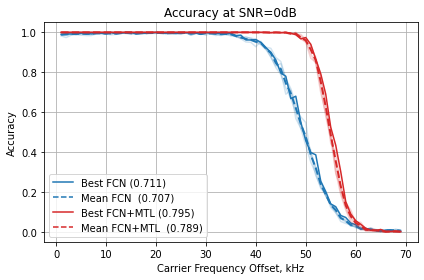

In [89]:
# plot_results(baseline_path='baseline/results/fs_baseline_-10db.pt', result_path='results/fs_0.9_0.1_-10db.pt')
# plot_results(baseline_path='baseline/results/fs_baseline_-5db.pt', result_path='results/fs_0.9_0.1_-5db.pt')
plot_results(baseline_path='baseline/results/fs_baseline_0db.pt', result_path='results/fs_0.9_0.1_0db.pt')
# plot_results(baseline_path='baseline/results/fs_baseline_5db.pt', result_path='results/fs_0.9_0.1_5db.pt')